<div style="
    font-family: Arial, sans-serif;
    font-size: 24px;
    font-weight: bold;
    background: linear-gradient(90deg, #6a11cb, #2575fc);
    color: white;
    padding: 20px;
    text-align: center;
    border-radius: 12px;
    width: 100%;
    box-sizing: border-box;
    box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    TAMATO DISEASE CLASSIFICATION
</div>



In [1]:
# prompt: moutt drive code

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 582.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [52]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import seaborn as sns


<div style="
    font-family: 'Courier New', monospace;
    font-size: 16px;
    background-color: #1e1e1e;
    color: #00ff00;
    padding: 20px;
    border-radius: 8px;
    width: 100%;
    box-sizing: border-box;
    overflow-x: auto;
    white-space: pre-wrap;
    box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d arjuntejaswi/plant-village
    !unzip plant-village.zip
</div>

```

In [5]:
dataset = keras.utils.image_dataset_from_directory(directory='/content/drive/MyDrive/Potato Image Classification/Potato',labels='inferred',label_mode='int',batch_size=32,image_size=(256,256),shuffle=True)

Found 2153 files belonging to 3 classes.


In [6]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

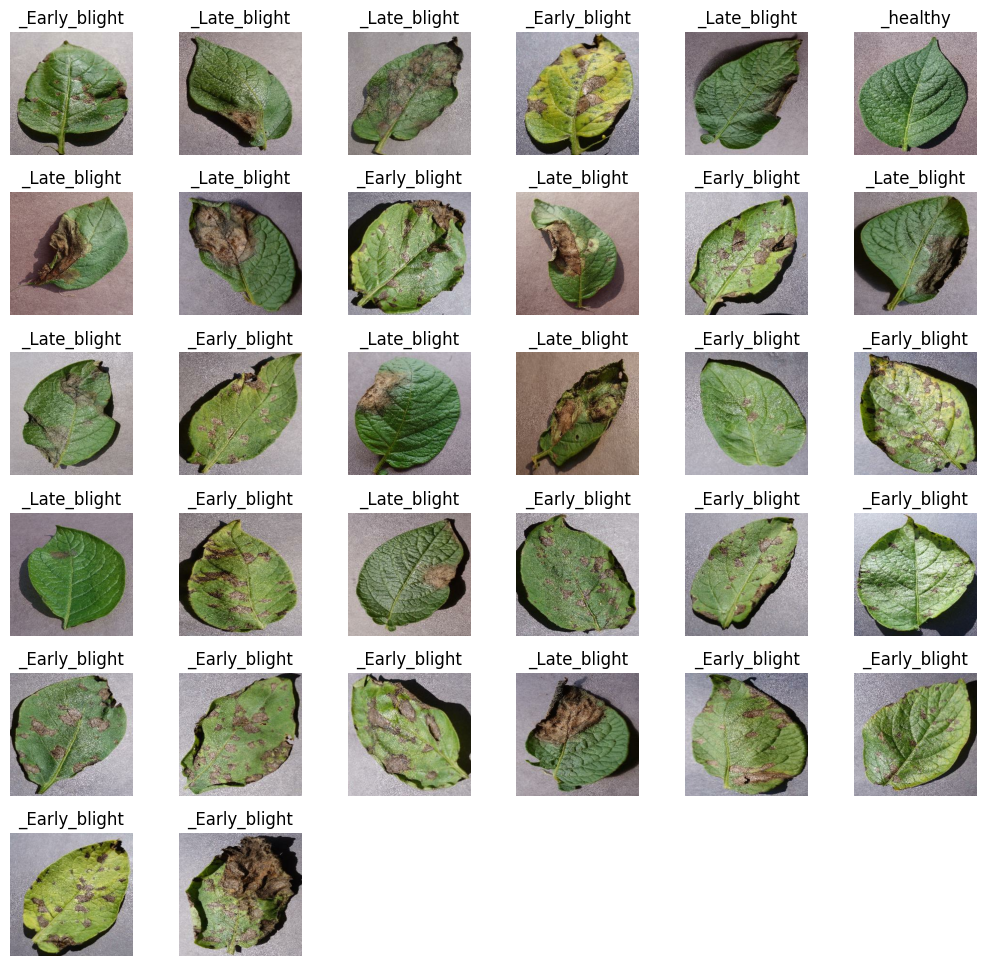

In [7]:
for image,label in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(32):
        plt.subplot(6,6,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[label[i].numpy()].split('__')[-1])
        plt.tight_layout()
        plt.axis('off')


In [8]:
print('Total Images',len(dataset)*32)

Total Images 2176


In [9]:
def splitting_dataset(dataset,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=10000):

    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)

    train_size =   int(len(dataset)*0.8)
    val_size   =   int(val_size*len(dataset))

    #training,test,val dataset
    train_ds   =   dataset.take(train_size)
    val_ds     =   dataset.skip(train_size).take(val_size)
    test_ds    =   dataset.skip(train_size).skip(val_size)

    return train_ds,test_ds,val_ds

In [10]:
train_ds,test_ds,val_ds = splitting_dataset(dataset)

In [11]:
print(f"""
The length of training data {len(train_ds)}
The length of test data : {len(test_ds)}
The length of valid test data : {len(val_ds)}
""")


The length of training data 54
The length of test data : 8
The length of valid test data : 6



- **`cache()`** → **Stores data in memory or disk** for faster access during training, reducing data loading time. Example:  
  ```python
  train_ds = train_ds.cache()
  ```

- **`prefetch()`** → **Fetches the next batch** of data in advance while the model is training, improving GPU/CPU utilization. Example:  
  ```python
  train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
  ```
- **`AUTOTUNE`** → Automatically adjusts based on system resources for optimal performance.

In [12]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
### Scaling the Images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256), ## Resizeing the image suppose if we give the other dimesions it new_test it reduce to this
    layers.Rescaling(1.0/255), ## normalizaing the images you cant mention or not
])

In [14]:
### Data Augmentaion
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.2),
    layers.RandomZoom(height_factor=(0.2, 0.3))
])

In [15]:
batch_size = 32
input_shape = (batch_size,256,256,3)
### Creating the CNN
model = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Conv2D(42,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Conv2D(62,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Conv2D(52,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Conv2D(52,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
    layers.MaxPool2D((2,2),padding='same'),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')

])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 128, 128, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 64, 64, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 32, 32, 42)            │          12,138 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 16, 16, 42)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 62)              │          23,498 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 4, 4, 62)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 2, 2, 52)              │          29,068 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 1, 1, 52)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 1, 1, 52)              │          24,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 1, 1, 52)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 52)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,575 (365.53 KB)

 Trainable params: 93,575 (365.53 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
## Compiler the model
model.compile(optimizer='adam',loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [19]:
## Fitting the model
history = model.fit(train_ds,batch_size=batch_size,epochs=25,verbose=1,validation_data=val_ds)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.8566 - loss: 0.3537 - val_accuracy: 0.8906 - val_loss: 0.3404
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.9388 - loss: 0.1731 - val_accuracy: 0.8333 - val_loss: 0.4066
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.9457 - loss: 0.1414 - val_accuracy: 0.8906 - val_loss: 0.3111
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.9385 - loss: 0.1435 - val_accuracy: 0.9427 - val_loss: 0.1802
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.9571 - loss: 0.1130 - val_accuracy: 0.9062 - val_loss: 0.2817
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.9563 - loss: 0.1053 - val_accuracy: 0.8542 - val_loss: 0.4091
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.9548 - loss: 0.1207 - val_accuracy: 0.8958 - val_loss: 0.2941
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.9674 - loss: 0.0891 - val_accu

# Model Evalution

In [21]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9017 - loss: 0.2164


[0.21116027235984802, 0.90625]

In [22]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

Text(0.5, 1.0, 'Accuracy')

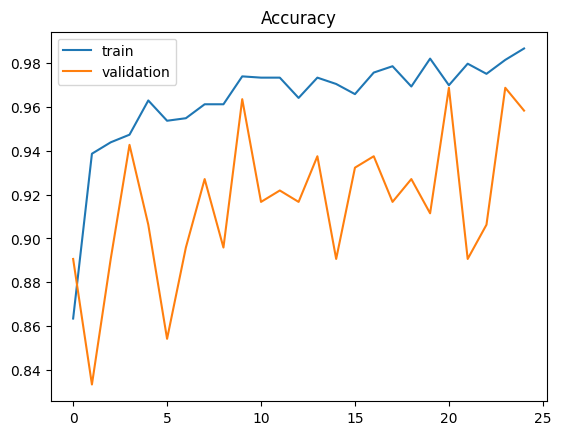

In [23]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

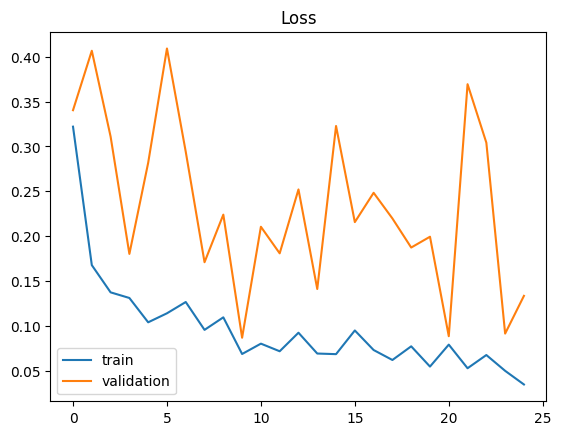

In [24]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Potato___Early_blight


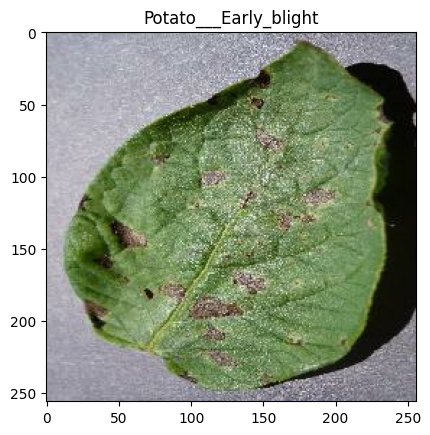

In [25]:
for image_batch ,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    #print(first_image)
    plt.imshow(first_image)
    plt.title(dataset.class_names[first_label])

    batch_predictin = model.predict(image_batch)
    print(dataset.class_names[np.argmax(batch_predictin[0])])


In [26]:
model.save('model.h5')